In [179]:
#import necessary packages
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

import scipy
from scipy import stats

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder 
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

import scipy
from scipy import stats

from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from sklearn.metrics import accuracy_score, confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [180]:
#import data
df=pd.read_csv('../data/AdSmartABdata.csv')# Store data in dataframe
df.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0


# Data preparation

In [181]:
df.isnull().sum()

auction_id     0
experiment     0
date           0
hour           0
device_make    0
platform_os    0
browser        0
yes            0
no             0
dtype: int64

In [182]:
#users who responde to the questionnair
df=df[(df['yes'] ==1)|(df['no']==1)]
#df.reset_index(drop=True)
#merge the information of yes and no to one column
df['response'] = df.yes
df.drop(['yes', 'no', 'auction_id'], axis=1, inplace=True)
df.head()

,experiment,date,hour,device_make,platform_os,browser,response
2,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0
16,exposed,2020-07-04,16,Generic Smartphone,6,Chrome Mobile,1
20,exposed,2020-07-06,8,Generic Smartphone,6,Chrome Mobile,0
23,control,2020-07-08,4,Samsung SM-A202F,6,Facebook,1
27,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0


### Split the data by browser and platform_os

In [183]:
browser = df.drop('platform_os', axis=1)
platform= df.drop('browser', axis=1)

browser.to_csv('../data/browser.csv',index=False)
platform.to_csv('../data/platform.csv',index=False)

platform.head()

,experiment,date,hour,device_make,platform_os,response
2,exposed,2020-07-05,2,E5823,6,0
16,exposed,2020-07-04,16,Generic Smartphone,6,1
20,exposed,2020-07-06,8,Generic Smartphone,6,0
23,control,2020-07-08,4,Samsung SM-A202F,6,1
27,control,2020-07-03,15,Generic Smartphone,6,0


In [184]:
browser.head()

,experiment,date,hour,device_make,browser,response
2,exposed,2020-07-05,2,E5823,Chrome Mobile WebView,0
16,exposed,2020-07-04,16,Generic Smartphone,Chrome Mobile,1
20,exposed,2020-07-06,8,Generic Smartphone,Chrome Mobile,0
23,control,2020-07-08,4,Samsung SM-A202F,Facebook,1
27,control,2020-07-03,15,Generic Smartphone,Chrome Mobile,0


### Encode catagorical dats

In [155]:
lb_encode = LabelEncoder()
def label_en(df):
    df['experiment'] = lb_encode.fit_transform(df['experiment'])
    df['date'] = lb_encode.fit_transform(df['date'])
    df['device_make'] = lb_encode.fit_transform(df['device_make'])
    if 'browser' in df.columns:
        df['browser'] = lb_encode.fit_transform(df['browser'])
label_en(browser)
label_en(platform)
browser.head()

,experiment,date,hour,device_make,browser,response
2,1,2,2,4,2,0
16,1,1,16,13,1,1
20,1,3,8,13,1,0
23,0,5,4,43,4,1
27,0,0,15,13,1,0


### Scale the data

In [156]:
scaler = MinMaxScaler()
def scale(df):
    scalled = scaler.fit_transform(df)
    scalled_df = pd.DataFrame(data = scalled, columns=df.columns)
    return scalled_df
browser=scale(browser)
platform=scale(platform)

In [171]:
def decision_tree(df):
    data_x = df.loc[:, df.columns != 'response']
    data_y = df['response']
    X_train, X_test, y_train, y_test\
    = train_test_split(data_x, data_y, test_size=0.3, random_state=1)
    X_val, X_test, y_val, y_test\
    = train_test_split(X_test, y_test, test_size=0.10, random_state=1)
    dt = DecisionTreeClassifier()
    dt.fit(X_train, y_train)
    dt.score(X_train, y_train)
    print(f"Decision Tree accuracy  score = {dt.score(X_train, y_train)}%")
    dt_result = cross_val_score(dt, X_train, y_train, cv=5)
    print(f"Decision Tree K=5 mean score accuracy = {round(dt_result.mean() * 100,2)} %")
    plt.figure(figsize=(12,7))
    sns.barplot(X_train.columns, dt.feature_importances_)
    plt.title('Decision Tree Classifier Feature Importance')
    plt.show()
    

In [170]:
def Logistic_reg(df):
    data_x = df.loc[:, df.columns != 'response']
    data_y = df['response']
    X_train, X_test, y_train, y_test\
    = train_test_split(data_x, data_y, test_size=0.3, random_state=1)
    X_val, X_test, y_val, y_test\
    = train_test_split(X_test, y_test, test_size=0.10, random_state=1)
    lr = LogisticRegression()
    lr.fit(X_train, y_train)
    print(f"Linear Regression accuracy  score = {lr.score(X_test, y_test)}%")
    
    lr_results = cross_val_score(lr, X_train, y_train, cv=5)
    print(f"Linear Regression K=5 mean score accuracy = {round(lr_results.mean() * 100,2)} %")
    
    plt.figure(figsize=(12,7))
    sns.barplot(X_train.columns, lr.coef_[0])
    plt.title('Linear Regression Feature Importance')
    plt.show()

In [172]:
def X_Boost(df):
    data_x = df.loc[:, df.columns != 'response']
    data_y = df['response']
    X_train, X_test, y_train, y_test\
    = train_test_split(data_x, data_y, test_size=0.3, random_state=1)
    X_val, X_test, y_val, y_test\
    = train_test_split(X_test, y_test, test_size=0.10, random_state=1)
    xb = XGBClassifier()
    xb.fit(X_train, y_train)
    print(f"XGBoost accuracy  score = {xb.score(X_test, y_test)}%")
    
    xb_results = cross_val_score(xb, X_train, y_train, cv=5)
    print(f"XGBoost K=5 mean score accuracy = {round(xb_results.mean() * 100,2)} %")
    
    '''plt.figure(figsize=(12,7))
    sns.barplot(X_train.columns, xb.feature_importances_)
    plt.title('XBoost Feature Importance')
    plt.show()
    '''
    plot_importance(xb,color='#B0C485')
    plt.show()
    
    

# Decision Tree 

In [185]:
decision_tree(browser)

ValueError: could not convert string to float: 'control'

###### For browser data, using Decision Tree Classifier hour,device_make,date  are the most contributers

Decision Tree accuracy  score = 0.8482758620689655%
Decision Tree K=5 mean score accuracy = 53.45 %


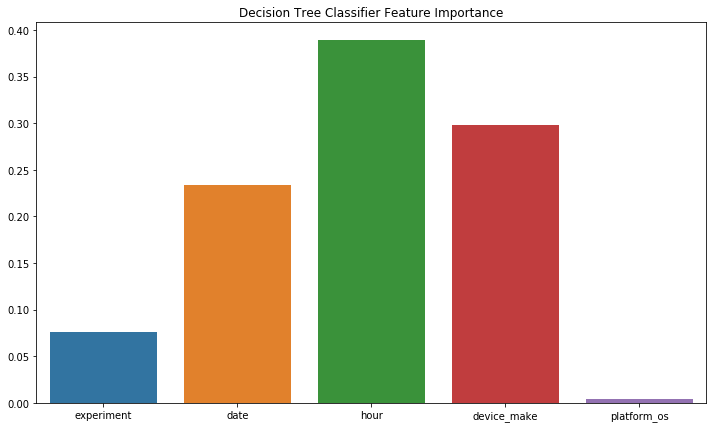

In [174]:
decision_tree(platform)

### for platform_os data,using Decision Tree Classifier model: hour,device_make,day are top 3 contributers

# Logistic Regression 

Linear Regression accuracy  score = 0.6052631578947368%
Linear Regression K=5 mean score accuracy = 52.99 %


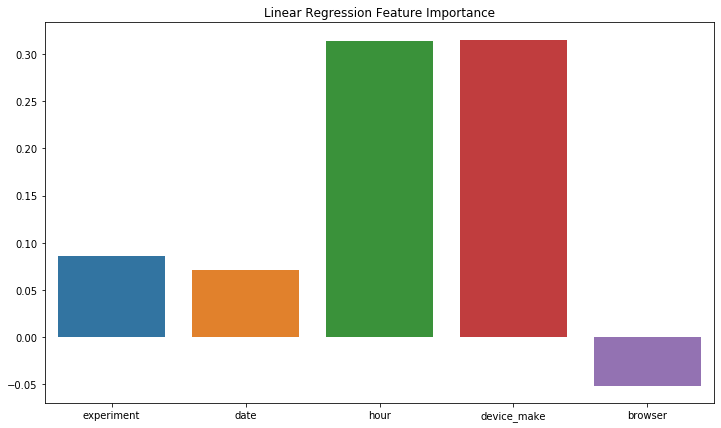

In [175]:
Logistic_reg(browser)

### browser data,using Logistic_regression model: experiment,hour,date are top contributers

Linear Regression accuracy  score = 0.6052631578947368%
Linear Regression K=5 mean score accuracy = 53.33 %


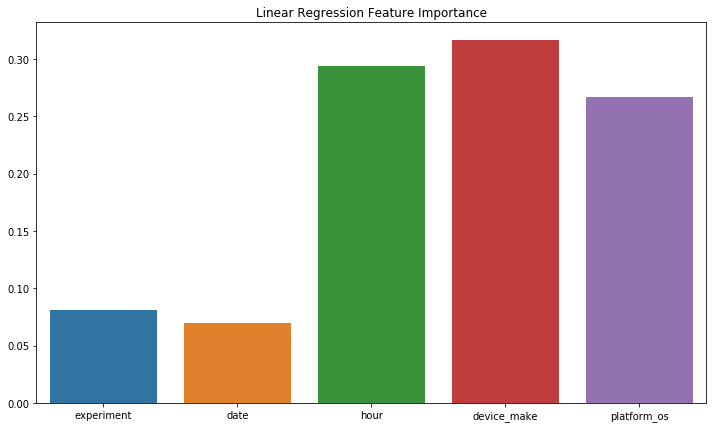

In [176]:
Logistic_reg(platform)

### for platform_os data,using Logistic_regression model: experiment,hour,date are top contributers

# xgboost

[10:28:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost accuracy  score = 0.5%
[10:28:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:28:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:28:25] WARNING: C:/Users/Administra

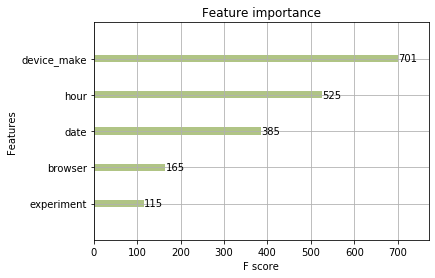

In [177]:
X_Boost(browser)

### For browser data, using Xgboost model device make, hour and date are top three contributers to #yes response

[10:28:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost accuracy  score = 0.47368421052631576%
[10:28:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:28:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:28:48] WARNING: C:/

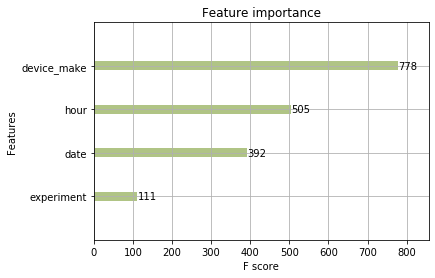

In [178]:
X_Boost(platform)

### For platform data, using Xgboost model device make, hour and date are top three contributers to #yes response